# 导入所需包

In [3]:
%matplotlib inline
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import sys
sys.path.append("..") 
import d2lzh_pytorch as d2l

print(torch.__version__)
torch.set_default_tensor_type(torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


2.3.0


# 导入数据集

In [4]:
train_labels = pd.read_csv('input/train_labels.csv')
train_sequences = pd.read_csv('input/train_sequences.csv')
test_sequences = pd.read_csv('input/test_sequences.csv')
valid_labels = pd.read_csv('input/validation_labels.csv')
valid_sequences = pd.read_csv('input/validation_sequences.csv')
submission = pd.read_csv('input/sample_submission.csv')

# 数据预处理

In [5]:
train_labels['target'] = train_labels['ID'].str.rsplit('_', n=1).str[0]
valid_labels['target'] = valid_labels['ID'].str.rsplit('_', n=1).str[0]

train = train_sequences.merge(train_labels, how='left', left_on='target_id', right_on='target')
validation = valid_sequences.merge(valid_labels, how='left', left_on='target_id', right_on='target')

train['temporal_cutoff'] = pd.to_datetime(train['temporal_cutoff']).astype('int64') 
test_sequences['temporal_cutoff'] = pd.to_datetime(test_sequences['temporal_cutoff']).astype('int64')
validation['temporal_cutoff'] = pd.to_datetime(validation['temporal_cutoff']).astype('int64')

In [6]:
submission['target'] = submission['ID'].str.rsplit('_', n=1).str[0]  # 提取目标RNA名称
test = test_sequences.merge(submission, how='left', left_on='target_id', right_on='target')

In [7]:
# 生成序列的长度
train['seq_length'] = train['sequence'].str.len()
test['seq_length'] = test['sequence'].str.len()
validation['seq_length'] = validation['sequence'].str.len()

In [8]:
train.head()

,target_id,sequence,temporal_cutoff,description,all_sequences,ID,resname,resid,x_1,y_1,z_1,target,seq_length
0,1SCL_A,GGGUGCUCAGUACGAGAGGAACCGCACCC,791078400000000000,"THE SARCIN-RICIN LOOP, A MODULAR RNA",>1SCL_1|Chain A|RNA SARCIN-RICIN LOOP|Rattus n...,1SCL_A_1,G,1,13.760,-25.974001,0.102,1SCL_A,29
1,1SCL_A,GGGUGCUCAGUACGAGAGGAACCGCACCC,791078400000000000,"THE SARCIN-RICIN LOOP, A MODULAR RNA",>1SCL_1|Chain A|RNA SARCIN-RICIN LOOP|Rattus n...,1SCL_A_2,G,2,9.310,-29.638000,2.669,1SCL_A,29
2,1SCL_A,GGGUGCUCAGUACGAGAGGAACCGCACCC,791078400000000000,"THE SARCIN-RICIN LOOP, A MODULAR RNA",>1SCL_1|Chain A|RNA SARCIN-RICIN LOOP|Rattus n...,1SCL_A_3,G,3,5.529,-27.813000,5.878,1SCL_A,29
3,1SCL_A,GGGUGCUCAGUACGAGAGGAACCGCACCC,791078400000000000,"THE SARCIN-RICIN LOOP, A MODULAR RNA",>1SCL_1|Chain A|RNA SARCIN-RICIN LOOP|Rattus n...,1SCL_A_4,U,4,2.678,-24.900999,9.793,1SCL_A,29
4,1SCL_A,GGGUGCUCAGUACGAGAGGAACCGCACCC,791078400000000000,"THE SARCIN-RICIN LOOP, A MODULAR RNA",>1SCL_1|Chain A|RNA SARCIN-RICIN LOOP|Rattus n...,1SCL_A_5,G,5,1.827,-20.136000,11.793,1SCL_A,29


# 特征补充

In [9]:
# --------------------------------------------------------------新加特征: 前两个碱基、后两个碱基--------------------------------------------------------------
# 原理：对于局部的特定结构可能会有相似的位置关系，比如"ACC"这三个连着的碱基，
# 它们可能都是有相似的相对关系，中间的C在上面旁边的AC在下面。
def prev_and_next(df):
    # 定义一个字典，指定要添加的上下文特征及其偏移量: 正值表示向前移动（获取前面的残基）, 负值表示向后移动（获取后面的残基）
    shifts = {
        'prev_res': 1,       # 前一个残基
        'next_res': -1,      # 后一个残基
        'prev_two_res': 2,   # 前两个残基
        'next_two_res': -2   # 后两个残基
    }

    # 生成前后残基，按RNA分组再shift
    for col_name, shift_value in shifts.items():
        df[col_name] = df.groupby('target_id')['resname'].shift(shift_value)

    for col in shifts.keys():
        df[col] = df[col].fillna('NA')  # 或使用其他合适的填充值
    
    return df

# --------------------------------------------------------------核苷酸组成特征（碱基组成特征）--------------------------------------------------------------
def add_nucleotide_composition(df):
    # 计算序列中GC含量(G+C碱基占总长度的比例)
    df['GC_content'] = df['sequence'].apply(lambda x: (x.count('G') + x.count('C'))/len(x))
    # 计算序列中AU含量(A+U碱基占总长度的比例)
    df['AU_content'] = df['sequence'].apply(lambda x: (x.count('A') + x.count('U'))/len(x))
    # 以及单独计算G、A、C、U的比例
    df['G_content'] = df['sequence'].apply(lambda x: x.count('G')/len(x))
    df['A_content'] = df['sequence'].apply(lambda x: x.count('A')/len(x))
    df['C_content'] = df['sequence'].apply(lambda x: x.count('C')/len(x))
    df['U_content'] = df['sequence'].apply(lambda x: x.count('U')/len(x))
    return df

# --------------------------------------------------------------局部结构复杂度--------------------------------------------------------------
def add_local_complexity(df):
    def calc_local_complexity_per_base(seq, position, window=3):
        start = max(0, position-window)
        end = min(len(seq), position+window+1)
        local_seq = seq[start:end]
        local_gc = (local_seq.count('G') + local_seq.count('C'))/len(local_seq)
        return local_gc
    
    # 直接在原始df上操作，不创建副本
    for _, group in df.groupby('target_id'):
        sequence = group['sequence'].iloc[0]
        
        local_complexity_values = []
        for i in range(len(sequence)):
            complexity = calc_local_complexity_per_base(sequence, i)
            local_complexity_values.append(complexity)
        
        for _, row in group.iterrows():
            position = int(row['resid']) - 1
            if 0 <= position < len(local_complexity_values):
                df.loc[row.name, 'local_complexity'] = local_complexity_values[position]
    
    return df

# --------------------------------------------------------------堆叠能量特征--------------------------------------------------------------
def add_stacking_energy(df):   # 定义堆叠能量参数 (kcal/mol)
    # 字典定义：创建包含所有16种可能二核苷酸堆叠能量值的字典
    # 数据来源：这些参数基于实验测定的热力学数据
    # 单位：千卡/摩尔(kcal/mol)，负值表示稳定相互作用
    # 物理意义：数值越小（越负）表示堆叠作用越稳定，如CC(-3.36)比AA(-0.93)更稳定
    stacking_energy = {
        'AA': -0.93, 'AC': -2.24, 'AG': -1.30, 'AU': -1.10,
        'CA': -2.11, 'CC': -3.36, 'CG': -2.36, 'CU': -2.08,
        'GA': -1.41, 'GC': -2.44, 'GG': -1.53, 'GU': -1.80,
        'UA': -0.90, 'UC': -1.70, 'UG': -1.80, 'UU': -0.80
    }
    
    def calc_avg_stacking(seq):
        if len(seq) <= 1:
            return 0
        energy = 0   # 累计总堆叠能量，初始为0
        pairs = 0    # 计数有效的二核苷酸对，初始为0
        
        # 遍历序列中的每个二核苷酸对（长度为2的子序列）
        for i in range(len(seq)-1):
            dinuc = seq[i:i+2]
            if dinuc in stacking_energy:
                energy += stacking_energy[dinuc]
                pairs += 1
        # 计算平均堆叠能量：将总能量除以有效的二核苷酸对数
        return energy/pairs if pairs > 0 else 0
    
    df['avg_stacking_energy'] = df['sequence'].apply(calc_avg_stacking)
    return df

# --------------------------------------------------------------结构模块特征--------------------------------------------------------------
def add_structural_motifs(df):
    # 常见的RNA结构模块模式:

    # tetraloop_GNRA: G + 任意核苷酸 + 嘌呤(A或G) + A
    # 功能：极其稳定的发夹环结构，常促进长程相互作用
    # 生物学意义：在核糖体RNA中高度保守，影响RNA整体折叠

    # tetraloop_UNCG: U + 任意核苷酸 + C + G
    # 功能：热力学上非常稳定的四核苷酸环
    # 生物学意义：能够稳定相邻的RNA结构元素

    # kink_turn: GA + 两个任意核苷酸 + A + 任意核苷酸 + A
    # 功能：导致RNA主链形成典型的"扭折"结构
    # 生物学意义：常见于复杂RNA结构的转角处，造成约120°的转弯

    # C_loop: CC + 任意两核苷酸(NN) + 5-7个任意核苷酸 + GG
    # 功能：形成特殊的RNA内部环状结构
    # 生物学意义：常与蛋白结合，参与RNA-蛋白互作
    motifs = {
        'tetraloop_GNRA': r'G[AGUC][AG]A',   
        'tetraloop_UNCG': r'U[AGUC]CG',       
        'kink_turn': r'GA[AGUC]{2}A[AGUC]A',  
        'C_loop': r'CC[AGUC]{2}[AGUC]{5,7}GG' # 可简化为CC[AGUC]{7,9}GG, 但保留结构语义
    }
    
    import re
    for motif_name, pattern in motifs.items():
        # 模式匹配：
        # re.search(pattern, x)：在序列x中搜索模式pattern
        # 返回值：找到匹配返回1，未找到返回0
        df[f'has_{motif_name}'] = df['sequence'].apply(
            lambda x: 1 if re.search(pattern, x) else 0)
    
    return df

In [10]:
# 应用特征工程 - 更简洁的方法
dataframes = [train, validation, test]
functions = [prev_and_next, add_nucleotide_composition, add_local_complexity, 
             add_stacking_energy, add_structural_motifs]

# 依次应用每个函数到每个数据框
for func in functions:
    dataframes = [func(df) for df in dataframes]

# 重新赋值回原变量
train, validation, test = dataframes

# 选择有效特征

In [11]:
categorical_columns = ['target_id','resname','seq_length','prev_res','next_res','prev_two_res','next_two_res','GC_content', 'AU_content', 
                       'G_content', 'A_content','C_content', 'U_content', 'local_complexity', 'avg_stacking_energy',
                       'has_tetraloop_GNRA', 'has_tetraloop_UNCG', 'has_kink_turn','has_C_loop']

labels_columns = ['x_1', 'y_1', 'z_1']  # 目标列

In [12]:
# 删掉不需要的列(文字描述的暂时没有办法有效处理, 先删掉, 后面再说)
def keep_only_categorical_columns(df, columns_to_keep):
    """
    删除数据框中不在指定列表的所有列
    
    参数:
    df (DataFrame): 需要处理的pandas数据框
    columns_to_keep (list): 要保留的列名列表
    
    返回:
    DataFrame: 只包含指定列的数据框
    """
    # 找出df中存在的列中包含在columns_to_keep中的列
    # 这样处理可以避免尝试访问不存在的列
    existing_columns = [col for col in columns_to_keep if col in df.columns]
    
    # 只保留这些列
    return df[existing_columns]

# 应用到所有三个数据集
train_labels = keep_only_categorical_columns(train, labels_columns)
valid_labels = keep_only_categorical_columns(validation, labels_columns)

Train = keep_only_categorical_columns(train, categorical_columns)
Test = keep_only_categorical_columns(test, categorical_columns)
Validation = keep_only_categorical_columns(validation, categorical_columns)

# 打印处理后的形状，验证结果
print(f"处理后的数据集形状:")
print(f"Train: {Train.shape}")
print(f"Test: {Test.shape}")
print(f"Validation: {Validation.shape}")

# 查看保留的列名
print("\n保留的列:")
print(Train.columns.tolist())

处理后的数据集形状:
Train: (137095, 19)
Test: (2515, 19)
Validation: (2515, 19)

保留的列:
['target_id', 'resname', 'seq_length', 'prev_res', 'next_res', 'prev_two_res', 'next_two_res', 'GC_content', 'AU_content', 'G_content', 'A_content', 'C_content', 'U_content', 'local_complexity', 'avg_stacking_energy', 'has_tetraloop_GNRA', 'has_tetraloop_UNCG', 'has_kink_turn', 'has_C_loop']


In [13]:
train_labels.head(5)  # 查看处理后的训练标签数据集的前5行

,x_1,y_1,z_1
0,13.760,-25.974001,0.102
1,9.310,-29.638000,2.669
2,5.529,-27.813000,5.878
3,2.678,-24.900999,9.793
4,1.827,-20.136000,11.793


In [14]:
train_labels['x_1'][0]

13.760000228881836

In [15]:
Train.head(5)

,target_id,resname,seq_length,prev_res,next_res,prev_two_res,next_two_res,GC_content,AU_content,G_content,A_content,C_content,U_content,local_complexity,avg_stacking_energy,has_tetraloop_GNRA,has_tetraloop_UNCG,has_kink_turn,has_C_loop
0,1SCL_A,G,29,NA,G,NA,G,0.655172,0.344828,0.344828,0.241379,0.310345,0.103448,0.750000,-1.941071,1,1,0,0
1,1SCL_A,G,29,G,G,NA,U,0.655172,0.344828,0.344828,0.241379,0.310345,0.103448,0.800000,-1.941071,1,1,0,0
2,1SCL_A,G,29,G,U,G,G,0.655172,0.344828,0.344828,0.241379,0.310345,0.103448,0.833333,-1.941071,1,1,0,0
3,1SCL_A,U,29,G,G,G,C,0.655172,0.344828,0.344828,0.241379,0.310345,0.103448,0.714286,-1.941071,1,1,0,0
4,1SCL_A,G,29,U,C,G,U,0.655172,0.344828,0.344828,0.241379,0.310345,0.103448,0.714286,-1.941071,1,1,0,0


单独保存训练集和验证集的target_id和seq_length，用于计算TM-score

In [16]:
train_ids_and_seqlength = Train[['target_id', 'seq_length']].copy()
valid_ids_and_seqlength = Validation[['target_id', 'seq_length']].copy()

print(train_ids_and_seqlength.head(5))  # 查看训练集的target_id和seq_length的前5行
print(train_ids_and_seqlength.shape)  # 查看训练集的target_id和seq_length的形状

print(train_ids_and_seqlength['target_id'][28], train_ids_and_seqlength['seq_length'][28])
print(train_ids_and_seqlength['target_id'][29], train_ids_and_seqlength['seq_length'][29])  # 查看训练集的唯一target_id数量
print(train_ids_and_seqlength.info())  # 查看训练集的唯一target_id数量

  target_id  seq_length
0    1SCL_A          29
1    1SCL_A          29
2    1SCL_A          29
3    1SCL_A          29
4    1SCL_A          29
(137095, 2)
1SCL_A 29
1RNK_A 34
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137095 entries, 0 to 137094
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   target_id   137095 non-null  object
 1   seq_length  137095 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.1+ MB
None


# 合并训练集和测试集

In [17]:
all_features = pd.concat((Train.iloc[:, 1:], Validation.iloc[:, 1:], Test.iloc[:, 1:]))
# 这里的iloc[:, 1:]表示选择所有行和从第二列开始的所有列（即去掉第一列target_id）
all_features.shape

(142125, 18)

# 数据编码-数据进阶处理

In [18]:
# all_features.dtypes：获取每一列的数据类型
# all_features.dtypes != 'object'：创建一个布尔掩码，标记非对象(非字符串)类型列
# [...].index：获取符合条件的列名索引
# 目的：识别数据集中的所有数值类型特征（区别于分类特征）
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index

# .apply()：对每列应用同一函数
# lambda x: (x - x.mean()) / (x.std())：标准化公式，转换每列为均值0、标准差1的分布
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))

# 标准化后，每个数值特征的均值变为0，所以可以直接用0来替换缺失值
all_features[numeric_features] = all_features[numeric_features].fillna(0)

In [19]:
# dummy_na=True将缺失值也当作合法的特征值并为其创建指示特征
# 主要作用：将分类特征(文本、枚举类型)转换为数值特征矩阵
# 处理对象：数据框中所有非数值型(object类型)的列
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(142125, 50)

In [20]:
all_features.head(5)  # 查看处理后的数据集的前5行

,seq_length,GC_content,AU_content,G_content,A_content,C_content,U_content,local_complexity,avg_stacking_energy,has_tetraloop_GNRA,...,prev_two_res_U,prev_two_res_X,prev_two_res_nan,next_two_res_-,next_two_res_A,next_two_res_C,next_two_res_G,next_two_res_NA,next_two_res_U,next_two_res_nan
0,-1.137244,1.197693,-1.197777,0.799443,0.107233,1.383775,-1.842679,0.987449,-1.349871,0.206617,...,False,False,False,False,False,False,True,False,False,False
1,-1.137244,1.197693,-1.197777,0.799443,0.107233,1.383775,-1.842679,1.233989,-1.349871,0.206617,...,False,False,False,False,False,False,False,False,True,False
2,-1.137244,1.197693,-1.197777,0.799443,0.107233,1.383775,-1.842679,1.398349,-1.349871,0.206617,...,False,False,False,False,False,False,True,False,False,False
3,-1.137244,1.197693,-1.197777,0.799443,0.107233,1.383775,-1.842679,0.811349,-1.349871,0.206617,...,False,False,False,False,False,True,False,False,False,False
4,-1.137244,1.197693,-1.197777,0.799443,0.107233,1.383775,-1.842679,0.811349,-1.349871,0.206617,...,False,False,False,False,False,False,False,False,True,False


In [21]:
# 将所有数据转换为浮点型
all_features = all_features.astype('float32')

n_train = Train.shape[0]   # 训练集的行数
n_test = Test.shape[0]     # 测试集的行数
n_valid = Validation.shape[0]   # 验证集的行数

# 特征和标签分离 - 修复版本
# 使用.to_numpy()明确转换为NumPy数组
train_features = torch.tensor(all_features[:n_train].to_numpy(), dtype=torch.float)
validation_features = torch.tensor(all_features[n_train:n_train+n_valid].to_numpy(), dtype=torch.float)
test_features = torch.tensor(all_features[n_train+n_valid:].to_numpy(), dtype=torch.float)

# 确保标签也是NumPy数组
train_labels = torch.tensor(train_labels.to_numpy() if isinstance(train_labels, pd.DataFrame) else train_labels, 
                           dtype=torch.float).view(-1, 3)
valid_labels = torch.tensor(valid_labels.to_numpy() if isinstance(valid_labels, pd.DataFrame) else valid_labels, 
                           dtype=torch.float).view(-1, 3)


In [22]:
train_labels.shape, valid_labels.shape, train_features.shape, validation_features.shape, test_features.shape

(torch.Size([137095, 3]),
 torch.Size([2515, 3]),
 torch.Size([137095, 50]),
 torch.Size([2515, 50]),
 torch.Size([2515, 50]))

In [23]:
# 查看训练和验证标签的前5行
print(train_labels[:5])
print(valid_labels[:5])  
print(train_labels[3, 2])  # 查看训练标签的第4行第3列, 确保其能通过索引访问

tensor([[ 13.7600, -25.9740,   0.1020],
        [  9.3100, -29.6380,   2.6690],
        [  5.5290, -27.8130,   5.8780],
        [  2.6780, -24.9010,   9.7930],
        [  1.8270, -20.1360,  11.7930]])
tensor([[-5.4990,  8.5200,  8.6050],
        [-5.8260, 10.4530, 14.0100],
        [-5.8490, 14.7680, 17.5850],
        [-5.7840, 19.9850, 18.6660],
        [-5.7550, 25.5330, 17.1330]])
tensor(9.7930)


In [24]:
from torch.utils.data import TensorDataset, DataLoader
# -------------------------下面用于测试数据集的创建和加载，查看数据集格式是否正确-------------------------

# # TensorDataset：将特征和标签组合成一个数据集对象，便于后续的批处理
# train_dataset = TensorDataset(train_features, train_labels)  # 创建训练集数据集对象
# valid_dataset = TensorDataset(validation_features, valid_labels)  # 创建验证集数据集对象
# test_dataset = TensorDataset(test_features)  # 创建测试集数据集对象（没有标签）

# # 创建DataLoader
# batch_size = 32  # 可以根据需要调整

# train_iter = DataLoader(
#     train_dataset, 
#     batch_size=batch_size, 
#     shuffle=True,  # 训练时打乱数据
#     num_workers=0  # Windows下建议使用0
# )

# valid_iter = DataLoader(
#     valid_dataset, 
#     batch_size=batch_size,
#     shuffle=False  # 验证不需要打乱
# )

# test_iter = DataLoader(
#     test_dataset, 
#     batch_size=batch_size,
#     shuffle=False  # 测试不需要打乱
# )

# # 验证数据集格式是否正确
# for X, y in train_iter:
#     print(f"特征批次形状: {X.shape}")  # 经验证是[32, 50]
#     print(f"标签批次形状: {y.shape}")  # 经验证是[32, 3]
#     print(f"第一个样本特征: {X[0][:5]}...")  # 展示部分特征
#     print(f"第一个样本标签: {y[0]}")  # 展示标签(x,y,z坐标)
#     break  # 只查看第一批次

In [25]:
# 多维回归的损失函数
def rmse_3d_loss_nan_safe(pred, target):
    # 创建布尔掩码，标记target中非NaN的元素。形状与target相同，值为True的位置表示该坐标有有效值
    mask = ~torch.isnan(target)
    
    # 创建样本掩码：只有当样本的所有三个坐标都是非NaN时才为True
    # all(dim=1)要求该行所有元素都为True
    sample_mask = mask.all(dim=1)  # 修改这里：从any改为all
    
    # 如果没有有效样本，返回零损失
    if sample_mask.sum() == 0:
        return torch.tensor(0.0, requires_grad=True)
    
    # 只针对完全有效的样本计算平方差
    valid_pred = pred[sample_mask]
    valid_target = target[sample_mask]
    
    # 计算有效样本的平方差之和
    squared_diff = (valid_pred - valid_target)**2
    squared_diff_sum = torch.sum(squared_diff, dim=1)
    
    # 返回有效样本的平均损失
    return torch.mean(squared_diff_sum)

# 使用MSE损失的替代方案
# loss_fn = nn.MSELoss()  # 会自动处理多维输出


In [26]:
x = torch.tensor([[1.0000, 12.0000, 17.0000], 
                  [2.0000, 13.0000, 18.0000], 
                  [3.0000, 14.0000, 19.0000], 
                  [4.0000, 15.0000, 20.0000], 
                  [5.0000, 16.0000, 21.0000], 
                  [6.0000, 17.0000, 22.0000]]) 
y = torch.tensor([[1.5000, 12.5000, 17.5000], 
                  [2.5000, 13.5000, 18.5000], 
                  [3.0000, 14.0000, 19.0000], 
                  [4.5000, 15.5000, 20.5000], 
                  [5.5000, 16.5000, 21.5000], 
                  [7.0000, 17.0000, 22.0000]])
print(rmse_3d_loss_nan_safe(x, y)) # 计算RMSE损失

# 点0: (1.0-1.5)² + (12.0-12.5)² + (17.0-17.5)² = 0.25 + 0.25 + 0.25 = 0.75
# 点1: (2.0-2.5)² + (13.0-13.5)² + (18.0-18.5)² = 0.25 + 0.25 + 0.25 = 0.75
# 点2: (3.0-3.0)² + (14.0-14.0)² + (19.0-19.0)² = 0 + 0 + 0 = 0
# 点3: (4.0-4.5)² + (15.0-15.5)² + (20.0-20.5)² = 0.25 + 0.25 + 0.25 = 0.75
# 点4: (5.0-5.5)² + (16.0-16.5)² + (21.0-21.5)² = 0.25 + 0.25 + 0.25 = 0.75
# 点5: (6.0-7.0)² + (17.0-17.0)² + (22.0-22.0)² = 1 + 0 + 0 = 1.0
# 平均值 = (0.75 + 0.75 + 0 + 0.75 + 0.75 + 1.0) / 6 = 4.0 / 6 = 0.6667

tensor(0.6667)


In [27]:
num_inputs = train_features.shape[1]  # 输入特征的维度
num_outputs = train_labels.shape[1]  # 输出目标的维度

# 创建一个带有丢弃法正则化的多层神经网络
def get_net(num_inputs, num_outputs=3, device='cuda'):
    """创建更宽、更有表达力的网络结构"""
    net = nn.Sequential(
        # 超宽输入层 - 大幅增加参数数量和表达能力
        nn.Linear(num_inputs, 512),
        nn.ReLU(),  # ReLU，更强的非线性能力
        
        # 保持宽层设计
        nn.Linear(512, 512),
        nn.ReLU(),
        
        # 增加一层宽层
        nn.Linear(512, 256),
        nn.ReLU(),
        
        # 输出前的最后处理
        nn.Linear(256, 128),
        nn.ReLU(),
        
        # 简单直接的输出层
        nn.Linear(128, num_outputs)
    ).to(device)
    
    # 使用He初始化，适合ReLU激活函数
    for m in net.modules():
        if isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
            if m.bias is not None:
                nn.init.zeros_(m.bias)
    
    return net   

num_inputs, num_outputs   # 打印网络参数

''' 补充-BatchNorm1d主要作用 '''
# 加速训练：减轻深层网络训练中的"内部协变量偏移"问题
# 提高稳定性：允许使用更高的学习率，对参数初始化不敏感
# 正则化效果：添加轻微的随机性，帮助模型泛化
# 解决梯度问题：缓解梯度消失/爆炸问题
# 平滑损失曲面：使优化过程更稳定  

' 补充-BatchNorm1d主要作用 '

In [28]:
net = get_net(num_inputs)  # 创建模型实例

# 测试：执行前向传播并获取输出
with torch.no_grad():
    output = net(train_features.float())

print(output.shape)   # 测试网络的输出形状，应该是[批次大小, 3]，即3D坐标
print(output.shape[0])  # 打印第一个维度大小(批次大小)
print(output[0])  # 打印第一个样本的输出坐标
print(output[0][1])  # 打印第一个样本的第一个坐标值，确保能通过索引访问，方便计算TM-score
print(f"Model device: {next(net.parameters()).device}")   # 打印模型参数所在的设备，确保在GPU上运行

torch.Size([137095, 3])
137095
tensor([ 1.4659,  0.0638, -0.6139])
tensor(0.0638)
Model device: cuda:0


# TM-score

In [29]:
def evaluation_function(ids_and_seqlength, output, train_labels):  
    ''' 修复变量名不一致问题 - 使用传入的参数名 '''
    # 分三种情况处理:
    # GPU上的张量：如果output是张量且在GPU上
    # output.cpu().numpy()：先将张量移至CPU，再转为NumPy数组
    # CPU上的张量：如果output是张量但在CPU上
    # output.numpy()：直接转换为NumPy数组
    # 已是NumPy数组：如果output不是张量
    # 直接使用output值
    pred = output.cpu().numpy() if torch.is_tensor(output) and output.is_cuda else (
        output.numpy() if torch.is_tensor(output) else output)
    
    target = train_labels.cpu().numpy() if torch.is_tensor(train_labels) and train_labels.is_cuda else (
        train_labels.numpy() if torch.is_tensor(train_labels) else train_labels)

    # 计算函数保持不变
    def calculate_d0(seq_len):
        if seq_len > 30:
            return 0.6*(seq_len-0.5)**0.5-2.5
        else:
            if seq_len < 12: return 0.3
            if seq_len < 16: return 0.4
            if seq_len < 20: return 0.5
            if seq_len < 24: return 0.6
            else: return 0.7
    
    def calculate_dis(x1, y1, z1, x2, y2, z2):
        # 处理空值
        if (np.isnan(x1) or np.isnan(y1) or np.isnan(z1) or 
            np.isnan(x2) or np.isnan(y2) or np.isnan(z2)):
            return float('inf')  # 返回无穷大使得得分为0
        return ((x1-x2)**2+(y1-y2)**2+(z1-z2)**2)**0.5
    
    def calculate_tm_score(ids_and_seqlength, pred, target):
        tm_score = []
        cur_id = ''
        cur_id_score = 0  # 初始化为0，避免未定义错误
        seq_len = 0  # 初始化为0，避免未定义错误
        
        for i in range(pred.shape[0]):
            try:
                ''' 获取当前ID,并处理可能的空值:"鸭子类型"(duck typing)的编程思想——关注对象的行为而非类型 '''
                # 1. hasattr(ids_and_seqlength['target_id'], 'iloc')
                # 这是一个动态检查，判断ids_and_seqlength['target_id']是否具有iloc属性
                # iloc是pandas的Series或DataFrame对象特有的属性，用于按位置索引
                # 2. 如果是pandas对象（条件为True）
                # 使用.iloc[i]方法按位置获取第i个元素
                # 这是pandas推荐的位置索引方法，避免了直接使用方括号索引可能导致的歧义
                # 3. 如果不是pandas对象（条件为False）
                # 使用标准的方括号索引：ids_and_seqlength['target_id'][i]
                # 这适用于Python列表、NumPy数组、字典等支持索引操作的数据结构
                current_id = ids_and_seqlength['target_id'].iloc[i] if hasattr(ids_and_seqlength['target_id'], 'iloc') else ids_and_seqlength['target_id'][i]
                
                # 如果是新序列
                if current_id != cur_id:
                    # 保存前一个序列得分（如果不是第一个序列）
                    if cur_id != '':
                        tm_score.append(cur_id_score/seq_len if seq_len > 0 else 0)
                    
                    # 获取新序列长度，处理可能的空值
                    seq_len = ids_and_seqlength['seq_length'].iloc[i] if hasattr(ids_and_seqlength['seq_length'], 'iloc') else ids_and_seqlength['seq_length'][i]
                    seq_len = 1 if seq_len <= 0 else seq_len  # 确保非零
                    
                    d0 = calculate_d0(seq_len)
                    # 计算当前位置得分
                    score_denominator = (calculate_dis(pred[i][0], pred[i][1], pred[i][2], 
                                                      target[i][0], target[i][1], target[i][2]))**2/d0**2
                    cur_id_score = 1/(1+score_denominator) if score_denominator != float('inf') else 0
                    
                    cur_id = current_id
                else:
                    # 累加得分
                    score_denominator = (calculate_dis(pred[i][0], pred[i][1], pred[i][2], 
                                                      target[i][0], target[i][1], target[i][2]))**2/d0**2
                    addition = 1/(1+score_denominator) if score_denominator != float('inf') else 0
                    cur_id_score += addition
            except Exception as e:
                print(f"Error at index {i}: {e}")
                continue  # 跳过有问题的数据
        
        # 添加最后一组数据（如果有）
        if cur_id != '':
            tm_score.append(cur_id_score/seq_len if seq_len > 0 else 0)
        
        # 安全计算均值
        return np.mean(tm_score) if len(tm_score) > 0 else 0
    
    with torch.no_grad():
        return calculate_tm_score(ids_and_seqlength, pred, target)

# 模型训练

下面的训练函数使用了Adam优化算法, 相对之前使用的小批量随机梯度下降, 它对学习率相对不那么敏感

In [30]:
import matplotlib.pyplot as plt

def train(net, train_features, train_labels, validation_features, valid_labels,
          num_epochs, learning_rate, weight_decay, batch_size, valid_ids_and_seqlength, device):
    ''' 确保网络在指定设备上 '''
    net = net.to(device)
    net = net.float()   # .float()方法将神经网络模型的所有参数转换为32位浮点数(float32)类型

    g = torch.Generator(device='cuda')  # 创建一个随机数生成器对象
    
    ''' 确保训练和验证数据在正确的设备上 '''
    train_features = train_features.to(device)
    train_labels = train_labels.to(device)
    validation_features = validation_features.to(device)
    valid_labels = valid_labels.to(device)
    
    valid_ls = []  # 用于存储每个epoch后的验证集TM-score

    ''' 创建训练集数据集对象 '''
    train_dataset = TensorDataset(train_features, train_labels)  
    train_iter = DataLoader(
        train_dataset, 
        batch_size=batch_size, 
        shuffle=True,   # 训练时打乱数据
        num_workers=0,  # Windows下建议使用0
        generator=g,    # 使用GPU进行数据加载
    )
    
    ''' 这里使用了Adam优化算法 '''
    optimizer = torch.optim.Adam(params=net.parameters(), lr=learning_rate, weight_decay=weight_decay) 

    ''' 训练时增加学习率衰减 '''
    # mode='max'：表示监控的指标是越大越好（如TM-score），若监控损失应设为'min'
    # factor=0.5：当性能不再提升时，学习率降低为原来的50%
    # patience=3：容忍3个epoch没有改进后再降低学习率
    # verbose=True：打印学习率变化信息
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=3, verbose=True
    )
    
    epoch_loss = []  # 用于存储每个epoch的损失值
    for epoch in range(num_epochs):
        # 设置为训练模式
        net.train()

        # 为每轮训练添加损失累计变量
        current_epoch_loss = 0
        num_batches = 0
        
        for X, y in train_iter:
            ''' 将数据移动到指定设备, 使用传入的device参数 '''
            X, y = X.to(device), y.to(device)   # 在损失计算中也确保输入和标签为32位浮点数类型
            
            # 前向传播和损失计算
            loss = rmse_3d_loss_nan_safe(net(X.float()), y.float())

            # 累计当前批次的损失值
            current_epoch_loss += loss.item()
            num_batches += 1
            
            # 反向传播和优化
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        # 计算并打印该轮的平均损失
        avg_loss = current_epoch_loss / num_batches
        epoch_loss.append(avg_loss)
        
        # 每个epoch结束后计算验证集的TM-score
        with torch.no_grad():
            # 设置模型为评估模式，禁用dropout等训练时特性
            net.eval()
            output = net(validation_features.float())
            TM_score = evaluation_function(valid_ids_and_seqlength, output, valid_labels)
            valid_ls.append(TM_score)
            print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.6f}, TM-score: {TM_score:.6f}')
        
        ''' 关键步骤：将验证指标传递给调度器 '''
        scheduler.step(TM_score)  # 使用TM-score作为监控指标

    return valid_ls, epoch_loss  # 返回验证集TM-score和训练损失

# 预测并在kaggle提交结果
下面定义预测函数。在预测之前，我们会使用完整的训练数据集来重新训练模型，并将预测结果存成提交所需要的格式

In [31]:
def train_and_pred(train_features, test_features, train_labels, validation_features, valid_labels,
                   num_epochs, lr, weight_decay, batch_size, valid_ids_and_seqlength, device='cuda'):
    """ 训练模型并生成预测结果 """
    # 设置设备
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    ''' 确保所有数据在同一设备上 '''
    train_features = train_features.to(device)
    train_labels = train_labels.to(device)
    validation_features = validation_features.to(device)
    valid_labels = valid_labels.to(device)
    test_features = test_features.to(device)
    
    ''' 创建并训练网络 '''
    net = get_net(train_features.shape[1], train_labels.shape[1], device)
    
    ''' 训练模型 '''
    valid_ls, epoch_loss = train(net, train_features, train_labels, validation_features, valid_labels,
                    num_epochs, lr, weight_decay, batch_size, valid_ids_and_seqlength, device)
           
    # 训练完成后，绘制验证集TM-score随训练轮数的变化曲线
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), valid_ls, marker='o', linestyle='-')
    plt.xlabel('epochs')
    plt.ylabel('TM-score')
    plt.title('Training Metrics')
    plt.grid(True)
    plt.show()
    
    print('valid_last_time TM-score %f' % valid_ls[-1])   # 打印最终验证集误差

    # 训练完成后，绘制训练集loss随训练轮数的变化曲线
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), epoch_loss, marker='o', linestyle='-')
    plt.xlabel('epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.grid(True)
    plt.show()
    
    print('valid_last_time TM-score %f' % epoch_loss[-1])   # 打印最终训练误差

    # 对测试集进行预测
    with torch.no_grad():
        net.eval()   # 设置模型为评估模式
        preds = net(test_features.float()).cpu().numpy()   # 预测并移回CPU, 转换为NumPy数组

    # 将预测结果转换为DataFrame格式，列名为['x_1', 'y_1', 'z_1']
    preds_df = pd.DataFrame(preds, columns=['x_1', 'y_1', 'z_1'])

    for i in range(2, 6):
        preds_df[f'x_{i}'] = preds_df['x_1']
        preds_df[f'y_{i}'] = preds_df['y_1']
        preds_df[f'z_{i}'] = preds_df['z_1']
    
    # 将预测结果添加到测试数据中
    submission[['x_1','y_1','z_1','x_2','y_2','z_2','x_3','y_3','z_3','x_4','y_4','z_4','x_5','y_5','z_5']] = preds_df[['x_1','y_1','z_1','x_2','y_2','z_2','x_3','y_3','z_3','x_4','y_4','z_4','x_5','y_5','z_5']] 

    submission.to_csv('submission.csv', index=False)

d:\anaconda\envs\DeepLearning\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/30, Loss: 23173.085971, TM-score: 0.022262
Epoch 2/30, Loss: 12455.541967, TM-score: 0.021106
Epoch 3/30, Loss: 9478.860313, TM-score: 0.018876
Epoch 4/30, Loss: 8096.384174, TM-score: 0.017769
Epoch 5/30, Loss: 7195.657150, TM-score: 0.021295
Epoch 6/30, Loss: 6017.562198, TM-score: 0.021165
Epoch 7/30, Loss: 5972.096081, TM-score: 0.021180
Epoch 8/30, Loss: 6017.656567, TM-score: 0.021458
Epoch 9/30, Loss: 5864.705135, TM-score: 0.021826
Epoch 10/30, Loss: 5286.327508, TM-score: 0.021439
Epoch 11/30, Loss: 5232.718480, TM-score: 0.020797
Epoch 12/30, Loss: 5074.115882, TM-score: 0.021399
Epoch 13/30, Loss: 4898.097861, TM-score: 0.022124
Epoch 14/30, Loss: 4241.233905, TM-score: 0.021987
Epoch 15/30, Loss: 4036.518725, TM-score: 0.021763
Epoch 16/30, Loss: 4004.736673, TM-score: 0.021741
Epoch 17/30, Loss: 3998.347083, TM-score: 0.021781
Epoch 18/30, Loss: 3875.906078, TM-score: 0.021440
Epoch 19/30, Loss: 3884.710199, TM-score: 0.021423
Epoch 20/30, Loss: 3873.551663, TM-sco

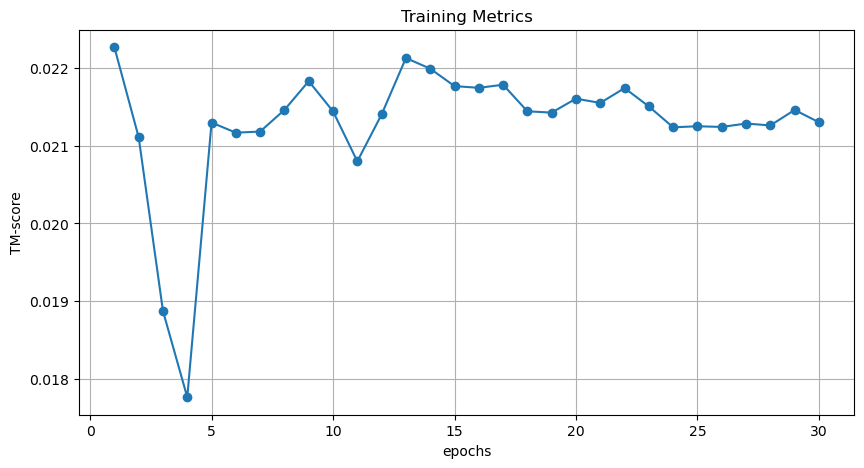

valid_last_time TM-score 0.021299


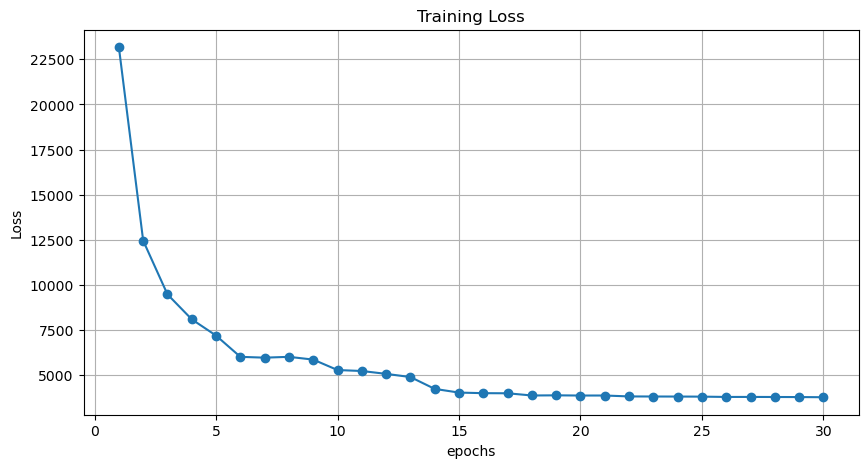

valid_last_time TM-score 3780.022744


In [32]:
num_epochs = 30  # 训练轮数
lr = 0.003  # 学习率
weight_decay = 0.001  # L2正则化系数
batch_size = 64  # 小批量大小(稍微增大批量，提高训练稳定性和速度)
train_and_pred(train_features, test_features, train_labels, validation_features, 
               valid_labels, num_epochs, lr, weight_decay, batch_size, valid_ids_and_seqlength)